# **Text Mining Project - Sentence Transformer for Information Retrieval on Medical documents**

*Author: Francesca Boccardi, francesca.boccardi@studio.unibo.it*

Given the large volume of clinical documents that medical professionals have to manage on a daily basis, there is an increasing need for Information Retrieval (IR) systems that enable an automatic and efficient access to medical information from big corpora of medical texts.

The peculiar and technical terminology used in Medicine requires the employment of domain-specific IR tools. Also, the widespread accessibility of medical information on Internet widens the users landscape, including both experts and non-experts people. Then, an effective IR tool must take into account the varying language skills of users, which may result in a lexical gap between user queries and medical information.

In this perspective, this project aims to address an IR task on the [NFCorpus](https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/), which contains natural language queries (written in non-technical English) and medical documents (written in a complex terminology-heavy language).

In particular, queries and documents embeddings are obtained by using a Sentence Transformer, properly trained on the NFCorpus with metric learning techniques. Then, embeddings are used for performing, given a certain query, k-NN search on documents.



# Import

In [ ]:
%%capture
! pip install sentence-transformers
! pip install datasets
! pip install pytorch-metric-learning
! pip install faiss-gpu
! pip install umap-learn

In [ ]:
import random
import os
import re
import pandas as pd
import numpy as np
from math import log2

import torch
from torch.utils.data import DataLoader

from sklearn.model_selection import GroupShuffleSplit

import nltk
from nltk.corpus import stopwords

from datasets import Dataset

from sentence_transformers import InputExample, SentenceTransformer, models, losses, evaluation, util, datasets
from sentence_transformers.losses.TripletLoss import TripletDistanceMetric
from sentence_transformers.util import cos_sim

import umap
import matplotlib.pyplot as plt
from cycler import cycler

import faiss
from faiss import index_factory

from google.colab import drive

In [ ]:
def set_reproducibility(seed):

  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  os.environ["PYTHONHASHSEED"] = str(seed)

set_reproducibility(42)

In [ ]:
#drive.mount('/content/drive')

# Dataset download and inspection

In [ ]:
# Download the dataset

%%capture
!wget https://www.cl.uni-heidelberg.de/statnlpgroup/nfcorpus/nfcorpus.tar.gz
!tar --gunzip --extract --verbose --file=nfcorpus.tar.gz

First, let's extract the documents dataset.

In [ ]:
######################## Docs df ##########################

docs = pd.read_csv('nfcorpus/raw/doc_dump.txt', sep="\t", header=None)
docs.columns = ["DOC_ID", "URL", "TITLE", "ABSTRACT"]
docs

,DOC_ID,URL,TITLE,ABSTRACT
0,MED-1,http://www.ncbi.nlm.nih.gov/pubmed/23092936,"Birth Weight, Head Circumference, and Prenatal...",Abstract Background: Acrylamide is a common di...
1,MED-2,http://www.ncbi.nlm.nih.gov/pubmed/22809476,A statistical regression model for the estimat...,Abstract Human exposure to acrylamide (AA) thr...
2,MED-3,http://www.ncbi.nlm.nih.gov/pubmed/19158207,Chronic intake of potato chips in humans incre...,Abstract BACKGROUND: Relatively high concentra...
3,MED-4,http://www.ncbi.nlm.nih.gov/pubmed/23651876,Dietary patterns and breast cancer risk among ...,Abstract OBJECTIVE: Breast cancer is the most ...
4,MED-5,http://www.ncbi.nlm.nih.gov/pubmed/16332665,Empirically derived dietary patterns and risk ...,Abstract BACKGROUND: Inconsistent associations...
...,...,...,...,...
5366,MED-5367,http://www.ncbi.nlm.nih.gov/pubmed/21929378,The relationship between plasma carotenoids an...,Abstract Objective We examined the cross-secti...
5367,MED-5368,http://www.ncbi.nlm.nih.gov/pubmed/24812159,Suicide Mortality in Relation to Dietary Intak...,Abstract Intake of n-3 and n-6 polyunsaturated...
5368,MED-5369,http://www.ncbi.nlm.nih.gov/pubmed/12803408,Suicide mortality in the European Union. - Pub...,Abstract BACKGROUND: There are an estimated on...
5369,MED-5370,http://www.ncbi.nlm.nih.gov/pubmed/17717628,"Long chain omega-3 fatty acids intake, fish co...",Abstract BACKGROUND: Very long chain omega-3 f...


In [ ]:
print('Total number of documents:', len(docs['DOC_ID'].unique()))
print('Number of unique documents:', len(docs['URL'].unique()))

Total number of documents: 5371
Number of unique documents: 3633


In [ ]:
# Abstract length

max_abs_length = int(max([len(d.split(" ")) for d in docs['ABSTRACT'].values.tolist()]))
print('Max length of documents abstract:', max_abs_length)

mean_abs_length = int(np.mean([len(d.split(" ")) for d in docs['ABSTRACT'].values.tolist()]))
print('Medium length of documents abstract:', mean_abs_length)

median_abs_length = int(np.median([len(d.split(" ")) for d in docs['ABSTRACT'].values.tolist()]))
print('Median length of documents abstract:', median_abs_length)

Max length of documents abstract: 1461
Medium length of documents abstract: 223
Median length of documents abstract: 228


Then, let's extract the queries dataset.

In [ ]:
########### Queries df ###################

queries_raw = pd.read_csv('nfcorpus/raw/nfdump.txt', sep="\t", header=None)
queries_raw.columns = ['ID', 'URL', 'TITLE', 'MAINTEXT', 'COMMENTS', 'TOPICS_TAGS', 'DESCRIPTION', 'DOCTORS_NOTE', 'ARTICLE_LINKS', 'QUESTION_LINKS', 'TOPIC_LINKS', 'VIDEO_LINKS', 'MEDARTICLE_LINKS']
queries_raw

,ID,URL,TITLE,MAINTEXT,COMMENTS,TOPICS_TAGS,DESCRIPTION,DOCTORS_NOTE,ARTICLE_LINKS,QUESTION_LINKS,TOPIC_LINKS,VIDEO_LINKS,MEDARTICLE_LINKS
0,PLAIN-1,http://nutritionfacts.org/2015/07/21/why-deep-...,Why Deep Fried Foods May Cause Cancer,In the latest study on dietary patterns and br...,"Even before the oil gets in the fryer, it’s be...","acrylamide,beans,breast cancer,cabbage,cancer,...",-,-,-,-,http://nutritionfacts.org/topics/organic-foods...,http://nutritionfacts.org/video/meat-fumes-die...,"http://www.ncbi.nlm.nih.gov/pubmed/23092936,ht..."
1,PLAIN-2,http://nutritionfacts.org/2015/07/16/do-choles...,Do Cholesterol Statin Drugs Cause Breast Cancer?,What does breast cancer have to do with choles...,"Off topic, but what does the science say about...","breast cancer,cancer,cancer survival,cardiovas...",-,-,-,-,http://nutritionfacts.org/topics/organic-foods...,http://nutritionfacts.org/video/statin-cholest...,"http://www.ncbi.nlm.nih.gov/pubmed/16565487,ht..."
2,PLAIN-3,http://nutritionfacts.org/2015/07/14/breast-ca...,Breast Cancer Cells Feed on Cholesterol,One in eight American women will be diagnosed ...,When I eat fresh stalks of celery my mouth goe...,"body fat,breast cancer,breast cancer survival,...",-,-,-,-,http://nutritionfacts.org/topics/organic-foods...,http://nutritionfacts.org/video/flaxseeds-brea...,"http://www.ncbi.nlm.nih.gov/pubmed/3081176,htt..."
3,PLAIN-4,http://nutritionfacts.org/2015/07/09/using-die...,Using Diet to Treat Asthma and Eczema,I previously discussed the power of fruits and...,I am confused about coconut fat. Is it the pro...,"asthma,blood pressure,caloric restriction,canc...",-,-,-,-,http://nutritionfacts.org/topics/organic-foods...,http://nutritionfacts.org/video/uprooting-the-...,"http://www.ncbi.nlm.nih.gov/pubmed/11840688,ht..."
4,PLAIN-5,http://nutritionfacts.org/2015/07/07/treating-...,Treating Asthma With Plants vs. Pills,In my video Treating Asthma With Fruits and Ve...,Maybe the asthma trick is in what not to eat. ...,"allergies,antioxidants,apples,asthma,beans,ber...",-,-,-,-,http://nutritionfacts.org/topics/organic-foods...,http://nutritionfacts.org/video/alkylphenol-en...,"http://www.ncbi.nlm.nih.gov/pubmed/21623967,ht..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3432,PLAIN-3470,http://nutritionfacts.org/video/more-than-an-a...,More Than an Apple a Day: Combating Common Dis...,"For those of you unfamiliar with my work, ever...",Fantastic presentation Dr. Greger! I enjoy you...,"abdominal fat,ADHD,aging,alternative medicine,...",Dr. Greger has scoured the world's scholarly l...,"In my annual nutrition review last year, Uproo...",-,-,http://nutritionfacts.org/topics/immune-functi...,http://nutritionfacts.org/video/uprooting-the-...,-
3433,PLAIN-3471,http://nutritionfacts.org/video/uprooting-the-...,Uprooting the Leading Causes of Death,"For those of you unfamiliar with my work, ever...",Today’s video-of-the-day is a NutritionFacts.o...,"acaí berries,adolescence,Adventist Health Stud...",Death in America is largely a foodborne illnes...,Today's video-of-the-day is a NutritionFacts.o...,http://nutritionfacts.org/2012/07/09/uprooting...,-,http://nutritionfacts.org/topics/immune-functi...,-,"http://www.ncbi.nlm.nih.gov/pubmed/19641302,ht..."
3434,PLAIN-3472,http://nutritionfacts.org/video/how-doctors-re...,How Doctors Responded to Being Named a Leading...,"Previously, I profiled a paper that added up a...",it will be good to control the drugs levels an...,"alcohol,aspirin,cardiovascular disease,cardiov...",What was the medical community’s reaction to b...,The third leading cause of death? Make sure yo...,-,-,http://nutritionfacts.org/topics/medical-ethic...,http://nutritionfacts.org/video/cancer-risk-fr...,"http://www.ncbi.nlm.nih.gov/pubmed/6474229,htt..."
3435,PLAIN-3473,http://nutritionfacts.org/video/does-rye-bread...,Does Rye Bread Protect Against Cancer?,Previously I’ve explored the beneficial effect...,Great as always. Thanks Dr. G. Do pre-ground f...,"adolescence,al

In [ ]:
# Maintext length

max_text_length = int(max([len(q.split(" ")) for q in queries_raw['MAINTEXT'].values.tolist()]))
print('Max length of queries main text:', max_text_length)

mean_text_length = int(np.mean([len(q.split(" ")) for q in queries_raw['MAINTEXT'].values.tolist()]))
print('Medium length of queries main text:', mean_text_length)

median_text_length = int(np.median([len(q.split(" ")) for q in queries_raw['MAINTEXT'].values.tolist()]))
print('Median length of queries main text:', median_text_length)

Max length of queries main text: 10552
Medium length of queries main text: 204
Median length of queries main text: 40


In [ ]:
quant_8 = int(np.quantile([len(seq.split(" ")) for seq in queries_raw['MAINTEXT'].values.tolist()], 0.8))
print('0.8 quantile of queries main text length:', quant_8)

0.8 quantile of queries main text length: 407


In [ ]:
# Title length

max_title_length = int(max([len(q.split(" ")) for q in queries_raw['TITLE'].values.tolist()]))
print('Max length of queries title:', max_title_length)

mean_title_length = int(np.mean([len(q.split(" ")) for q in queries_raw['TITLE'].values.tolist()]))
print('Medium length of queries title:', mean_title_length)

median_title_length = int(np.median([len(q.split(" ")) for q in queries_raw['TITLE'].values.tolist()]))
print('Median length of queries title:', median_title_length)

Max length of queries title: 18
Medium length of queries title: 3
Median length of queries title: 2


It may be noted that the main query texts are rather long. Therefore, for computational reasons, it was decided to consider the concatenation of only the title and main text as query texts, without considering the other available fields.

In [ ]:
# Creating the text of queries as a concatenation of title + main text

queries = queries_raw[queries_raw['MAINTEXT']!='-'] # filtering out queries without main text
queries = queries.rename(columns={'ID':'QUERY_ID'})
queries['TEXT'] = queries['TITLE'] + queries['MAINTEXT']
queries = queries.drop(['URL', 'TITLE', 'MAINTEXT', 'COMMENTS', 'TOPICS_TAGS', 'DESCRIPTION', 'DOCTORS_NOTE', 'ARTICLE_LINKS', 'QUESTION_LINKS', 'TOPIC_LINKS', 'VIDEO_LINKS', 'MEDARTICLE_LINKS'], axis=1)
queries

,QUERY_ID,TEXT
0,PLAIN-1,Why Deep Fried Foods May Cause CancerIn the la...
1,PLAIN-2,Do Cholesterol Statin Drugs Cause Breast Cance...
2,PLAIN-3,Breast Cancer Cells Feed on CholesterolOne in ...
3,PLAIN-4,Using Diet to Treat Asthma and EczemaI previou...
4,PLAIN-5,Treating Asthma With Plants vs. PillsIn my vid...
...,...,...
3432,PLAIN-3470,More Than an Apple a Day: Combating Common Dis...
3433,PLAIN-3471,Uprooting the Leading Causes of DeathFor those...
3434,PLAIN-3472,How Doctors Responded to Being Named a Leading...
3435,PLAIN-3473,Does Rye Bread Protect Against Cancer?Previous...


The NFCorpus also provides information about the relevance between queries and documents. In particular, `query_doc` dataframe contains *(query_id, doc_id)* positive pairs with the related relevance level, which can take the value $1$ or $2$. The relevance level of all *(query_id, doc_id)* pairs not present in the dataframe must be considered $0$, i.e. the *doc_id* is not relevant for the *query_id*.

In [ ]:
########### Queries-Docs relevance df ###################

query_doc_1 = pd.read_csv('nfcorpus/train.2-1-0.qrel', sep="\t", header=None)
query_doc_2 =  pd.read_csv('nfcorpus/dev.2-1-0.qrel', sep="\t", header=None)
query_doc_3 = pd.read_csv('nfcorpus/test.2-1-0.qrel', sep="\t", header=None)

query_doc = pd.concat([query_doc_1, query_doc_2], axis=0)
query_doc = pd.concat([query_doc, query_doc_3], axis=0)
query_doc.columns = ['QUERY_ID', '0', 'DOC_ID', 'RELEVANCE_LEVEL']
query_doc = query_doc.drop(['0'], axis=1)

query_doc

,QUERY_ID,DOC_ID,RELEVANCE_LEVEL
0,PLAIN-3,MED-2436,2
1,PLAIN-3,MED-2437,2
2,PLAIN-3,MED-2438,2
3,PLAIN-3,MED-2439,2
4,PLAIN-3,MED-2440,2
...,...,...,...
12329,PLAIN-3472,MED-3623,1
12330,PLAIN-3472,MED-3624,1
12331,PLAIN-3472,MED-3625,1
12332,PLAIN-3472,MED-3626,1


In [ ]:
query_doc['RELEVANCE_LEVEL'].unique()

array([2, 1])

Now let's merge all useful information in one single dataset.

In [ ]:
######## Merging docs/queries-docs/queries ##########

df = query_doc.merge(docs.drop(['URL','TITLE'],axis=1), on='DOC_ID', how='inner')
df = df.rename(columns={'ABSTRACT':'TEXT_DOC',})
df = df.merge(queries, on='QUERY_ID')
df = df.rename(columns={'TEXT':'TEXT_Q'})
df

,QUERY_ID,DOC_ID,RELEVANCE_LEVEL,TEXT_DOC,TEXT_Q
0,PLAIN-3,MED-2436,2,Abstract The content of low density lipoprotei...,Breast Cancer Cells Feed on CholesterolOne in ...
1,PLAIN-3,MED-2437,2,Abstract BACKGROUND: Breast cancer is the most...,Breast Cancer Cells Feed on CholesterolOne in ...
2,PLAIN-3,MED-2438,2,Abstract Phytoestrogens are structurally simil...,Breast Cancer Cells Feed on CholesterolOne in ...
3,PLAIN-3,MED-2439,2,Abstract While many factors are involved in th...,Breast Cancer Cells Feed on CholesterolOne in ...
4,PLAIN-3,MED-2440,2,Abstract Purpose To further clarify the relati...,Breast Cancer Cells Feed on CholesterolOne in ...
...,...,...,...,...,...
95215,PLAIN-3285,MED-4914,2,Abstract As one of the major agricultural crop...,Toxins in Cooked Potatoes?Any other natural to...
95216,PLAIN-3285,MED-4915,2,Abstract A quantitative human dietary risk ass...,Toxins in Cooked Potatoes?Any other natural to...
95217,PLAIN-428,MED-924,2,Abstract Oral ingestion of baking soda (sodium...,"In making water alkaline, how much baking soda..."
95218,PLAIN-428,MED-925,2,Abstract We present a case of a six-week-old i...,"In making water alkaline, how much baking soda..."


# Train/val/test split

Then, let's split the whole dataset in train/val/test sets.

In [ ]:
# Splitting

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(df, groups=df['QUERY_ID'])
train_inds, test_inds = next(split)

df_train_temp = df.iloc[train_inds].reset_index(drop=True)

splitter = GroupShuffleSplit(test_size=.25, n_splits=2, random_state = 7)
split = splitter.split(df_train_temp, groups=df_train_temp['QUERY_ID'])
train_inds, val_inds = next(split)

df_train = df_train_temp.iloc[train_inds].reset_index(drop=True)
df_val = df_train_temp.iloc[val_inds].reset_index(drop=True)
df_test = df.iloc[test_inds].reset_index(drop=True)

print('Df_train shape:', df_train.shape)
print('Df_val shape:', df_val.shape)
print('Df_test shape:', df_test.shape)

Df_train shape: (50930, 5)
Df_val shape: (20307, 5)
Df_test shape: (23983, 5)


In [ ]:
df_train

,QUERY_ID,DOC_ID,RELEVANCE_LEVEL,TEXT_DOC,TEXT_Q
0,PLAIN-755,MED-2436,1,Abstract The content of low density lipoprotei...,"breast cancerMuch like other types of cancer, ..."
1,PLAIN-755,MED-2437,1,Abstract BACKGROUND: Breast cancer is the most...,"breast cancerMuch like other types of cancer, ..."
2,PLAIN-755,MED-2438,1,Abstract Phytoestrogens are structurally simil...,"breast cancerMuch like other types of cancer, ..."
3,PLAIN-755,MED-2439,1,Abstract While many factors are involved in th...,"breast cancerMuch like other types of cancer, ..."
4,PLAIN-755,MED-2440,1,Abstract Purpose To further clarify the relati...,"breast cancerMuch like other types of cancer, ..."
...,...,...,...,...,...
50925,PLAIN-3348,MED-5021,2,Abstract We have previously discovered that st...,"Are Star Fruit Good For You?Star fruit, which ..."
50926,PLAIN-3377,MED-5059,2,Abstract This report represents the conclusion...,"Is Gum Arabic Harmful?Gum Arabic, found in pai..."
50927,PLAIN-428,MED-924,2,Abstract Oral ingestion of baking soda (sodium...,"In making water alkaline, how much baking soda..."
50928,PLAIN-428,MED-925,2,Abstract We present a case of a six-week-old i...,"In making water alkaline, how much baking soda..."


For convenience, *query-doc* positive pairs and related relevances are extracted and collected in dictionaries using proper functions.

In [ ]:
def get_query_docs_rel_order(df):

  """
  Creates a dictionary where the keys are the query IDs and the values are the lists of relevant document IDs sorted by relevance level (in descending order).

  Parameters:
  df (pd.DataFrame): The dataframe that contains information about the query-document pairs and related relevance.

  Returns:
  query_doc_rel_order (dict): A dictionary where each key is a query ID and each value is a list of relevant document IDs sorted by relevance level.
  """

  grouped_docs = df.groupby('QUERY_ID')

  query_doc_rel_order = {} # for each q contains the list of related docs sorted by descending relevance

  for q in grouped_docs.groups.keys():
    grouped_df = grouped_docs.get_group(q).reset_index()
    query_doc_rel_order[q] = grouped_df.sort_values(by='RELEVANCE_LEVEL', ascending=False)['DOC_ID'].values.tolist()

  return query_doc_rel_order

In particular, `query_docs_rel_order` dictionary maps each query with the list of its relevant documents ids, sorted by descending relevance level. The `qd_rel` dictionary maps instead the positive pairs *(query_id, document_id)* with the correspondent relevance level.

In [ ]:
train_query_docs_rel_order = get_query_docs_rel_order(df_train)
val_query_docs_rel_order = get_query_docs_rel_order(df_val)
test_query_docs_rel_order = get_query_docs_rel_order(df_test)

train_qd_rel = dict(zip(zip(df_train['QUERY_ID'], df_train['DOC_ID']), df_train['RELEVANCE_LEVEL']))
val_qd_rel = dict(zip(zip(df_val['QUERY_ID'], df_val['DOC_ID']), df_val['RELEVANCE_LEVEL']))
test_qd_rel = dict(zip(zip(df_test['QUERY_ID'], df_test['DOC_ID']), df_test['RELEVANCE_LEVEL']))

# Text pre-processing

In information retrieval tasks, performance usually benefits from pre-processing the text. In this case, it was decided to remove punctuation, numbers and stopwords from both queries and documents, significantly reducing their length, which is good also considering the computational limits.

In [ ]:
##### Pre-processing functions ########

# Download stopwords
nltk.download('stopwords')
stopwords_ita = stopwords.words('english')

def remove_punct_number(text):
  """
  Removes punctuation and numbers from the input text.

  Parameters:
  - text (str): The input text.

  Returns:
  - str: The cleaned text with punctuation and numbers removed.

  """
  text_clean = re.sub(r"[^a-zA-Z\s]", '', text)
  return text_clean


def remove_stopwords(text):
  """
  Removes English stopwords from the input text.

  Parameters:
  - text (str): The input text.

  Returns:
  - str: The cleaned text with stopwords removed.

  """
  return ' '.join([word for word in text.lower().split() if word not in (stopwords_ita)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess_q_text(df):

  """
  Preprocesses the queries texts of the dataframe `df` by removing punctuations and stopwords.

  Parameters:
  - df (pandas.DataFrame): The dataframe containing the queries texts.

  Returns:
  - dict: A dictionary mapping query IDs to their cleaned text.
  """

  grouped_query = df.groupby('QUERY_ID')
  qid_text = {} # q -> clean_text

  for q in grouped_query.groups.keys():
    grouped_df = grouped_query.get_group(q).reset_index()
    clean_q_text = remove_punct_number(grouped_df['TEXT_Q'].values.tolist()[0])
    clean_q_text = remove_stopwords(clean_q_text)
    qid_text[q] = clean_q_text

  return qid_text


def preprocess_d_text(df):

  """
  Preprocess the documents texts of the dataframe `df` by removing punctuation and stopwords.

  Parameters:
  df (pandas DataFrame): A dataframe containing the documents texts.

  Returns:
  docid_text (dict): A dictionary mapping document IDs to the corresponding cleaned text.
  """

  grouped_doc = df.groupby('DOC_ID')
  docid_text = {} # d -> clean_text

  for d in grouped_doc.groups.keys():
    grouped_df = grouped_doc.get_group(d).reset_index()
    clean_d_text = remove_punct_number(grouped_df['TEXT_DOC'].values.tolist()[0])
    clean_d_text = remove_stopwords(clean_d_text)
    docid_text[d] = clean_d_text

  return docid_text

Let's apply pre-processing functions on all queries and documents texts.

`qid_text` and `docid_text` are two dictionaries mapping respectively query ids and documents ids to their corresponding cleaned text.

In [ ]:
train_qid_text = preprocess_q_text(df_train)
val_qid_text = preprocess_q_text(df_val)
test_qid_text = preprocess_q_text(df_test)

train_docid_text = preprocess_d_text(df_train)
val_docid_text = preprocess_d_text(df_val)
test_docid_text = preprocess_d_text(df_test)

Let's now inspect how much queries and documents length have been reduced.

In [ ]:
max_text_length = int(max([len(d.split(" ")) for d in train_docid_text.values()]))
print('Max length of train documents text after pre-processing:', max_text_length)

mean_text_length = int(np.mean([len(d.split(" ")) for d in train_docid_text.values()]))
print('Medium length of train documents text after pre-processing:', mean_text_length)

median_text_length = int(np.median([len(d.split(" ")) for d in train_docid_text.values()]))
print('Median length of train documents text after pre-processing:', median_text_length)

Max length of train documents text after pre-processing: 906
Medium length of train documents text after pre-processing: 135
Median length of train documents text after pre-processing: 137


In [ ]:
max_text_length = int(max([len(q.split(" ")) for q in train_qid_text.values()]))
print('Max length of train queries text after pre-processing:', max_text_length)

mean_text_length = int(np.mean([len(q.split(" ")) for q in train_qid_text.values()]))
print('Medium length of train queries text after pre-processing:', mean_text_length)

median_text_length = int(np.median([len(q.split(" ")) for q in train_qid_text.values()]))
print('Median length of train queries text after pre-processing:', median_text_length)

Max length of train queries text after pre-processing: 3995
Medium length of train queries text after pre-processing: 229
Median length of train queries text after pre-processing: 188


# Dataset Utils

The `triplets_format` function creates *(anchor, positive, negative)* triplets, where *(anchor, positive)* are *(query, document)* pairs already collected in the original dataset. For each positive pair, the *negative* document is randomly selected among the documents that do not have any query in common with the positive one, i.e. does not exist one query for which both of them are relevant.

In [ ]:
########### Converting the dataset in (anchor, positive, negative) format ###############

def triplets_format(dataset, qid_text, docid_text):

    """
    Convert the dataset into triplets format.
    Each triplet contains:
    - A query ID
    - A positive document ID
    - A negative document ID
    - The text of the query
    - The text of the positive document
    - The text of the negative document
    - The relevance level of the positive document

    Parameters:
    - dataset (pandas dataframe) : The dataset with columns: 'QUERY_ID', 'DOC_ID', 'RELEVANCE_LEVEL'.
    - qid_text (dictionary) : The text of each query, with query IDs as keys and text as values.
    - docid_text (dictionary) : The text of each document, with document IDs as keys and text as values.

    Returns:
    - df (pandas dataframe) : The triplets dataset with columns: 'QUERY_ID', 'POS_DOC_ID', 'NEG_DOC_ID', 'TEXT_Q', 'TEXT_POS_DOC', 'TEXT_NEG_DOC', 'RELEVANCE_LEVEL'.
    """

    docs_q_dict = {} # for each doc, it contains the list of related queries

    for d in set(dataset['DOC_ID'].values.tolist()):
      docs_q_dict[d] = dataset[dataset['DOC_ID'] == d]['QUERY_ID'].values.tolist()

    all_docs_id = dataset['DOC_ID'].unique().tolist() # list of all the docs ids

    df = []

    for idx, row in dataset.iterrows(): # iterate over the rows

      flag = False

      while not flag:
        neg_doc = all_docs_id[np.random.randint(len(all_docs_id))] # select a random negative doc

        # if the negative doc and the positive one don't share any query, confirm the selection
        if (set(docs_q_dict[neg_doc]) & set(docs_q_dict[row['DOC_ID']])) == set():
          flag = True

      data = {'QUERY_ID' : row['QUERY_ID'],
              'POS_DOC_ID' : row['DOC_ID'],
              'NEG_DOC_ID': neg_doc,
              'TEXT_Q' : qid_text[row['QUERY_ID']],
              'TEXT_POS_DOC' : docid_text[row['DOC_ID']],
              'TEXT_NEG_DOC' : docid_text[neg_doc],
              'RELEVANCE_LEVEL' : row['RELEVANCE_LEVEL']}

      df.append(data)

    df = pd.DataFrame(df)

    return df

The `pairs_format` function creates negative *(query, documents)* pairs starting from the positive ones collected in the original dataframe. In particular, it assigns the label $1$ to each *(query, pos_document)* positive pairs, and for each of them create a *(query, neg_document)* negative pair with label $0$, by randomly selecting a negative document among all documents non-relevant for the *query*.

In [ ]:
########### Converting the dataset into (query, doc, label) format ###############

def pairs_format(dataset, qid_text, docid_text):

    docs_q_dict = {} # for each doc contains the list of related queries (all grades of relevance)

    for d in set(dataset['DOC_ID'].values.tolist()):
      docs_q_dict[d] = dataset[dataset['DOC_ID'] == d]['QUERY_ID'].values.tolist()

    all_docs_id = dataset['DOC_ID'].unique().tolist()

    df = []

    for idx, row in dataset.iterrows(): # iterate over the rows

      flag = False

      while not flag:
        neg_doc = all_docs_id[np.random.randint(len(all_docs_id))] # select a random negative doc

        if row['QUERY_ID'] not in docs_q_dict[neg_doc]: # if the selected negative document is not among the relevant documents of the query, confirm the selection
          flag = True

      # Positive pair
      row_pos = {'QUERY_ID' : row['QUERY_ID'],
              'DOC_ID' : row['DOC_ID'],
              'TEXT_Q' : qid_text[row['QUERY_ID']],
              'TEXT_DOC' : docid_text[row['DOC_ID']],
              'LABEL': 1,
              'RELEVANCE_LEVEL' : row['RELEVANCE_LEVEL']}

      # Negative pair
      row_neg = {'QUERY_ID' : row['QUERY_ID'],
              'DOC_ID' : neg_doc,
              'TEXT_Q' : qid_text[row['QUERY_ID']],
              'TEXT_DOC' : docid_text[neg_doc],
              'LABEL': 0,
              'RELEVANCE_LEVEL' : 0}


      df.append(row_pos)
      df.append(row_neg)

    df = pd.DataFrame(df)

    return df

# Sentence Transformer

Sentence Transformers are made up of two modules: a Transformer model and a pooling layer.

In this case, the Transformer model used is [bert-mini](https://huggingface.co/prajjwal1/bert-mini), a light pre-trained BERT version. The choice of such a small model is mainly due to computational limits.

The Sentence Transformer takes the text as input and outputs the correspondent embedding. Then, the embeddings will be used for performing k-NN search on documents, given a certain query.

In order to investigate the contribute of each of them, the model is trained with $3$ different loss functions:
* Contrastive Loss
* Multiple Negative Ranking Loss
* Triplet Loss

## Metrics Functions Utils

For evaluating results of the information retrieval search, the following metrics are implemented and computed:

* Precision@k
* Recall@k
* F1-score@k
* R-precision
* MAP@k
* NDCG@k

In [ ]:
def precision_at_k(query_id, results, docid_text, query_docs_ids, k):

  """
  Calculate the precision at k for a given query.

  Parameters:
  - query_id (int): The identifier of the query.
  - results (list): A list of indices of the retrieved documents.
  - docid_text (dict): A dictionary mapping document identifier to document text.
  - query_docs_ids (dict): A dictionary mapping query identifier to a list of relevant document identifiers.
  - k (int): The number of retrieved documents to consider for the calculation.

  Returns:
  - pk (float): The precision at k for the query.
  """

  retrieved_docs = results[0:k]
  id_retrieved_docs = [list(docid_text.keys())[d] for d in retrieved_docs]
  pk = len(set(id_retrieved_docs) & set(query_docs_ids[query_id])) / k

  return pk

In [ ]:
def recall_at_k(query_id, results, docid_text, query_docs_ids, k):

  """
  Calculate the recall at k for a given query.

  Parameters:
  - query_id (int): The identifier of the query.
  - results (list): A list of indices of the retrieved documents.
  - docid_text (dict): A dictionary mapping document identifier to document text.
  - query_docs_ids (dict): A dictionary mapping query identifier to a list of relevant document identifiers.
  - k (int): The number of retrieved documents to consider for the calculation.

  Returns:
  - rk (float): The recall at k for the query.
  """

  retrieved_docs = results[0:k]
  id_retrieved_docs = [list(docid_text.keys())[d] for d in retrieved_docs]
  rk = len(set(id_retrieved_docs) & set(query_docs_ids[query_id])) / len(query_docs_ids[query_id])

  return rk

In [ ]:
def f1_at_k(query_id, results, docid_text, query_docs_ids, k):

  """
  Calculates the F1-score at k for the given query id.

  Parameters:
  - query_id (int): The query identifier
  - results (list): A list of indices of the retrieved documents.
  - docid_text (dict): A dictionary mapping document identifier to document text.
  - query_docs_ids (dict): A dictionary mapping query identifier to a list of relevant document identifiers.
  - k (int): The number of retrieved documents to consider for the calculation.

  Returns:
  float: F1-score at k

  """

  pk = precision_at_k(query_id, results, docid_text, query_docs_ids, k)
  rk = recall_at_k(query_id, results, docid_text, query_docs_ids, k)

  if(pk != 0 or rk != 0):
    return 2*(pk * rk)/(pk+rk)
  else:
    return 0

In [ ]:
def r_precision(query_id, results, docid_text, query_docs_ids):

  """
  Calculates the R-Precision metric for a given query, set of results and information about relevant documents.

  Parameters:
  - query_id (int): The identifier for the query.
  - results (list): A list of indices of the retrieved documents.
  - docid_text (dict): A dictionary mapping document identifier to document text.
  - query_docs_ids (dict): A dictionary mapping query identifier to a list of relevant document identifiers.

  Returns:
  - float: The R-Precision score.
  """

  R = len(query_docs_ids[query_id])
  retrieved_docs = results[0:R]
  id_retrieved_docs = [list(docid_text.keys())[d] for d in retrieved_docs]
  r = len(set(id_retrieved_docs) & set(query_docs_ids[query_id]))

  return r/R

In [ ]:
def mean_average_precision_at_k(query_id, results, docid_text, query_docs_ids, K):

    """
    Calculate the mean average precision at K (MAP@K) for a given query

    Parameters:
    - query_id (int): Identifier of the query.
    - results (list): A list of indices of the retrieved documents.
    - docid_text (dict): A dictionary mapping document identifier to document text.
    - query_docs_ids (dict): A dictionary mapping query identifier to a list of relevant document identifiers.
    - K (int): the number of documents to consider for MAP@K calculation.

    Returns:
    float: the mean average precision at K (MAP@K) for the given query
    """

    ap_num = 0

    for k in range(1,K+1):

      retrieved_docs = results[0:k]
      id_retrieved_docs = [list(docid_text.keys())[d] for d in retrieved_docs]

      for d in id_retrieved_docs:
        if d in query_docs_ids[query_id]:
          ap_num += precision_at_k(query_id, results, docid_text, query_docs_ids, k)

    return ap_num / len(query_docs_ids[query_id])

In [ ]:
def compute_ndcg_at_k(query_id, results, docid_text, query_doc_rel, query_doc_order, K):

  """
  Compute the Normalized Discounted Cumulative Gain (NDCG) at k for a given query.

  Parameters:
      query_id (int): The id of the query.
      results (list): A list of indices of the retrieved documents.
      docid_text (dict): A mapping from document id to its text.
      query_doc_rel (dict): A mapping from (q_id, doc_id) pairs to relevance scores.
      query_doc_order (dict): A mapping from each query id to a list of relevant document ids in order of importance.
      K (int): The value of k in NDCG@k.

  Returns:
      float: The NDCG value.
  """

  dcg = 0
  idcg = 0

  for k in range(1, K+1):
      retrieved_docs = results[0:k]
      id_retrieved_docs = [list(docid_text.keys())[d] for d in retrieved_docs]

      # predicted relevance
      if (query_id, id_retrieved_docs[k-1]) in query_doc_rel.keys():
        pred_rel_k = query_doc_rel[(query_id, id_retrieved_docs[k-1])]
      else:
        pred_rel_k = 0

      # true relevance
      if k <= len(query_doc_order[query_id]):
        ideal_doc_k = query_doc_order[query_id][k-1]
        ideal_rel_k = query_doc_rel[(query_id, ideal_doc_k)]
      else:
        ideal_rel_k = 0

      # calculate dcg and idcg
      dcg += pred_rel_k / log2(1 + k)
      idcg += ideal_rel_k / log2(1 + k)


  ndcg_at_k = dcg / idcg

  return ndcg_at_k

## Model Loading

Before starting the training, let's upload the pre-trained model and use it to create embeddings of test queries and documents text.

In [ ]:
word_embedding_model = models.Transformer('prajjwal1/bert-mini')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
# Using the model for generating embeddings

docs_embeddings = model.encode(list(test_docid_text.values()), convert_to_tensor=True)
q_embeddings = model.encode(list(test_qid_text.values()), convert_to_tensor=True)

docs_embeddings = docs_embeddings.cpu().numpy()
q_embeddings = q_embeddings.cpu().numpy()

## Latent space visualization before training

For visualizing the embeddings in a 2D space, it can be used a dimensionality reduction algorithm called UMAP.

In [ ]:
umap_visualizer = umap.UMAP(random_state = 56)
umap_visualizer.fit(np.concatenate((docs_embeddings, q_embeddings)))
docs_embeddings_reduced = umap_visualizer.transform(docs_embeddings)
q_embeddings_reduced = umap_visualizer.transform(q_embeddings)

For visualization purposes, it can be useful to focus on a single query and its relevant documents.

In [ ]:
# Select one query

idx = list(test_qid_text.keys()).index('PLAIN-2989')
query_id = list(test_qid_text.keys())[idx]
query_text = list(test_qid_text.values())[idx]
query_id

'PLAIN-2989'

In [ ]:
# Extract relevant docs

docs_ids = test_query_docs_rel_order[query_id]
docs_text = [test_docid_text[d] for d in docs_ids]
docs_ids

['MED-4415',
 'MED-4416',
 'MED-4417',
 'MED-4418',
 'MED-3811',
 'MED-3812',
 'MED-3813',
 'MED-4389']

In [ ]:
def visualize_embeddings(embeddings_reduced, q_docs_ids, all_docs_ids, q_embeddings, idx, q_id):

  """
  Function to visualize documents and queries embeddings in a 2D plot. It highlights the position of `q_id` query and of its relevant documents, whose ids are contained in `q_docs_ids`.

  Parameters:
  - embeddings_reduced (np.ndarray): 2D array of reduced document embeddings.
  - q_docs_ids (list): List of ids for documents which are relevant for the query and have to be highlighted.
  - all_docs_ids (list): List of ids for all documents.
  - q_embeddings (np.ndarray): 2D array of reduced query embeddings.
  - idx (int): Index in the list of all queries of the query to be highlighted.
  - q_id (str): Id of the query to be highlighted.

  """

  fig = plt.figure(figsize=(20, 15))

  # Visualize documents
  plt.plot(embeddings_reduced[:, 0], embeddings_reduced[:, 1], '.', markersize=1, color = 'red', label='Document')

  for i in range(len(all_docs_ids)):
    if all_docs_ids[i] in q_docs_ids:
      plt.annotate(all_docs_ids[i], # annotation text
                  (embeddings_reduced[i, 0], embeddings_reduced[i, 1]), # coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(0,1), # distance from text to points (x,y)
                  ha='center')

  # Visualize queries
  plt.plot(q_embeddings[:idx, 0], q_embeddings[:idx, 1], '*', markersize=1, color='blue', label='Query')
  plt.plot(q_embeddings[idx, 0], q_embeddings[idx, 1], '*', markersize=20, color='blue')
  plt.plot(q_embeddings[idx+1:, 0], q_embeddings[idx+1:, 1], '*', markersize=1, color='blue')

  plt.annotate(q_id, # annotation text
              (q_embeddings[idx, 0], q_embeddings[idx, 1]), # coordinates to position the label
              textcoords="offset points", # how to position the text
              xytext=(1,1), # distance from text to points (x,y)
              ha='center')

  plt.legend(loc='best',markerscale=10)
  plt.show()

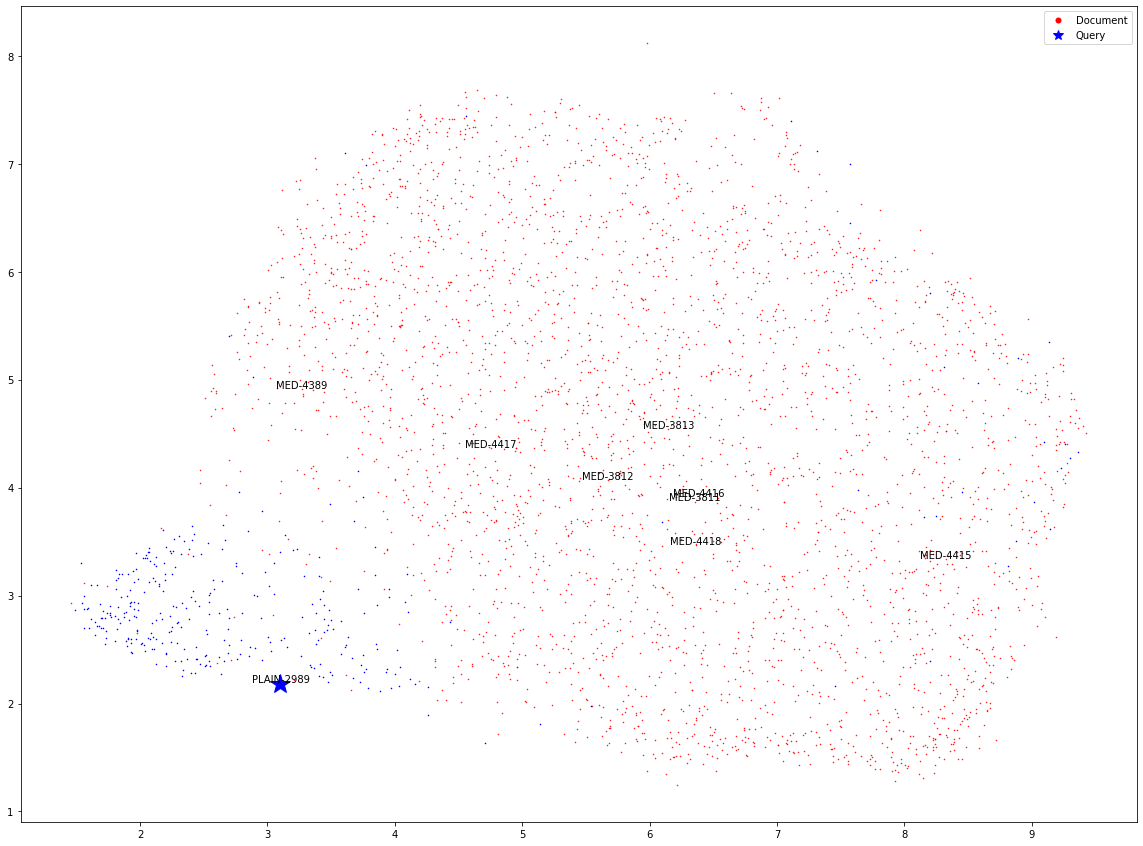

In [ ]:
# Visualize embedding space

visualize_embeddings(docs_embeddings_reduced, docs_ids, list(test_docid_text.keys()), q_embeddings_reduced, idx, query_id)

Before training the model, the query and its documents embeddings are quite far from each other.

## Contrastive Loss

### Data formatting

Before feeding the model, data must be formatted properly. In particular, to be able to train the model using Contrastive Loss, the input must be in the format *(query, pos_document, label=1)*, *(query, neg_document, label=0)* , where *pos_document* is one relevant document for the *query* while and *neg_document* is a non-relevant one.

Since the dataset only contains pairs of *(query, pos_document)*, the negative must be set manually using the `pairs_format` function.

In [ ]:
df_train_pairs = pairs_format(df_train, train_qid_text, train_docid_text)
df_test_val = pairs_format(df_val, val_qid_text, val_docid_text)
df_test_pairs = pairs_format(df_test, test_qid_text, test_docid_text)

In [ ]:
df_train_pairs

,QUERY_ID,DOC_ID,TEXT_Q,TEXT_DOC,LABEL,RELEVANCE_LEVEL
0,PLAIN-755,MED-2436,breast cancermuch like types cancer plantbased...,abstract content low density lipoprotein ldl r...,1,1
1,PLAIN-755,MED-1409,breast cancermuch like types cancer plantbased...,abstract study compares prevalence coronary he...,0,0
2,PLAIN-755,MED-2437,breast cancermuch like types cancer plantbased...,abstract background breast cancer commonly dia...,1,1
3,PLAIN-755,MED-5287,breast cancermuch like types cancer plantbased...,abstract limited research examining relationsh...,0,0
4,PLAIN-755,MED-2438,breast cancermuch like types cancer plantbased...,abstract phytoestrogens structurally similar e...,1,1
...,...,...,...,...,...,...
101855,PLAIN-428,MED-4896,making water alkaline much baking soda muchhtt...,abstract background westernized societies acne...,0,0
101856,PLAIN-428,MED-925,making water alkaline much baking soda muchhtt...,abstract present case sixweekold infant develo...,1,2
101857,PLAIN-428,MED-1357,making water alkaline much baking soda muchhtt...,abstract background previous observational int...,0,0
101858,PLAIN-428,MED-926,making water alkaline much baking soda muchhtt...,abstract case severe metabolic alkalosis resul...,1,2


### Training

In [ ]:
# Load a new bert-mini model

word_embedding_model = models.Transformer('prajjwal1/bert-mini')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
# Convert the dataframe into a dataset

train_ds = Dataset.from_pandas(df_train_pairs)
train_ds

Dataset({
    features: ['QUERY_ID', 'DOC_ID', 'TEXT_Q', 'TEXT_DOC', 'LABEL', 'RELEVANCE_LEVEL'],
    num_rows: 101860
})

In [ ]:
# Format properly the input

train_samples = []
train_data = train_ds
n_samples = train_ds.num_rows

for i in range(n_samples):
  sample = train_data[i]
  train_samples.append(InputExample(texts=[sample['TEXT_Q'], sample['TEXT_DOC']], label=sample['LABEL'] ))

In [ ]:
# Collect train data into a dataloader

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=32)

In [ ]:
# Define the loss function

train_loss = losses.OnlineContrastiveLoss(model=model, margin=0.1)

In [ ]:
# Define an evaluator on validation data

evaluator = evaluation.InformationRetrievalEvaluator(queries = val_qid_text,
                                                     corpus = val_docid_text,
                                                     relevant_docs = val_query_docs_rel_order,
                                                     accuracy_at_k = [1, 3, 5, 10],
                                                     precision_recall_at_k = [1, 3, 5, 10],
                                                     map_at_k = [1, 3, 5, 10],
                                                     show_progress_bar=True,
                                                     score_functions = {'cos_sim': cos_sim})

In [ ]:
# Train the model for 3 epochs

model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=3,
          evaluator=evaluator,
          output_path = 'model_contrastive_loss/',
          evaluation_steps = 5000,
          save_best_model=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3184 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


Iteration:   0%|          | 0/3184 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.46s/it]


Iteration:   0%|          | 0/3184 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.24s/it]


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_contrastive_loss')

Let's see the results on the validation set during the $3$ epochs of training.

In [ ]:
results = pd.read_csv('model_contrastive_loss/eval/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10'], axis=1)
results

,epoch,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,cos_sim-Precision@5,cos_sim-Recall@5,cos_sim-Precision@10,cos_sim-Recall@10,cos_sim-MAP@1,cos_sim-MAP@3,cos_sim-MAP@5,cos_sim-MAP@10
0,0,0.320242,0.528701,0.619335,0.709970,0.320242,0.030834,0.255791,0.048472,0.217523,0.064016,0.177644,0.087090,0.320242,0.219033,0.175476,0.133700
1,1,0.401813,0.595166,0.697885,0.791541,0.401813,0.029874,0.335347,0.057012,0.293051,0.076072,0.246828,0.112441,0.401813,0.293471,0.240541,0.186704
2,2,0.419940,0.613293,0.676737,0.773414,0.419940,0.025223,0.357503,0.058781,0.319033,0.080994,0.276133,0.119770,0.419940,0.320074,0.270023,0.219604


In [ ]:
# Reload the model

#model = SentenceTransformer('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_contrastive_loss')

In [ ]:
#! mkdir '/content/contrastive_loss'

In [ ]:
#evaluator(model, output_path='/content/contrastive_loss')

In [ ]:
#results = pd.read_csv('/content/contrastive_loss/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10','epoch'], axis=1)
#results

### Latent space visualization after model training

Let the trained model to generate embeddings for test queries and documents.

In [ ]:
docs_embeddings = model.encode(list(test_docid_text.values()), convert_to_tensor=True)
q_embeddings = model.encode(list(test_qid_text.values()), convert_to_tensor=True)

docs_embeddings = docs_embeddings.cpu().numpy()
q_embeddings = q_embeddings.cpu().numpy()

In [ ]:
idx = list(test_qid_text.keys()).index('PLAIN-2989')
query_id = list(test_qid_text.keys())[idx]
query_text = list(test_qid_text.values())[idx]
query_id

'PLAIN-2989'

In [ ]:
docs_ids = test_query_docs_rel_order[query_id]
docs_text = [test_docid_text[d] for d in docs_ids]
docs_ids

['MED-4415',
 'MED-4416',
 'MED-4417',
 'MED-4418',
 'MED-3811',
 'MED-3812',
 'MED-3813',
 'MED-4389']

In [ ]:
umap_visualizer = umap.UMAP(random_state = 56)
umap_visualizer.fit(np.concatenate((docs_embeddings,q_embeddings)))
docs_embeddings_reduced = umap_visualizer.transform(docs_embeddings)
q_embeddings_reduced = umap_visualizer.transform(q_embeddings)

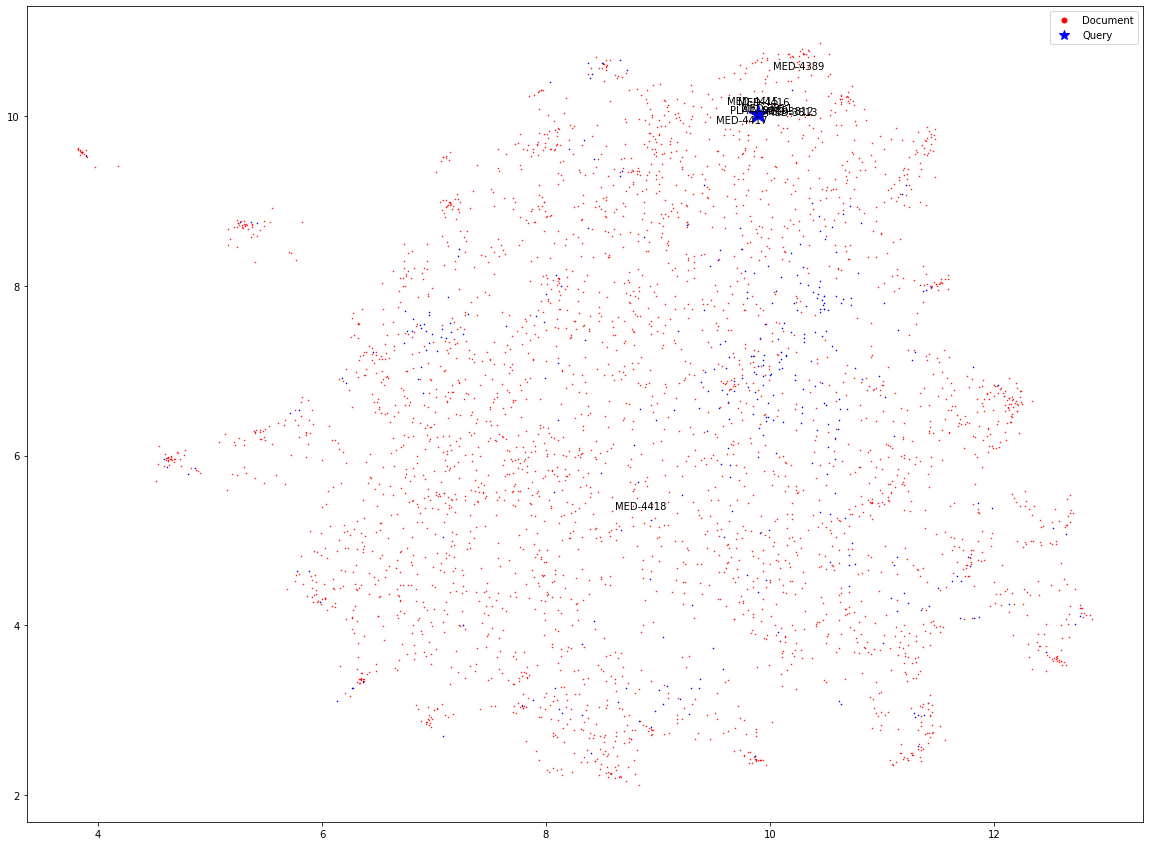

In [ ]:
visualize_embeddings(docs_embeddings_reduced, docs_ids, list(test_docid_text.keys()), q_embeddings_reduced, idx, query_id)

It can be clearly seen that the latent space is still spread but a little more clustered than before the training. Also, the embeddings of the query under analysis and most of its relevant documents collapse in close proximity.

### Documents retrieval

After obtaining the embeddings of queries and documents, they can be used for running information retrieval search on the corpus.

#### Cosine Similarity

First, it may be interesting to compute the cosine similarity between one query embedding and all documents embeddings, and to find out the pairs *query-document* with highest cosine similarity scores.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

cos_scores = util.cos_sim(q_embeddings[idx], docs_embeddings)[0]
top_results = torch.topk(cos_scores, k=10)

print("Query:", list(test_qid_text.keys())[idx])
print()
print('Clean text:', test_qid_text[query])
print("\nTop 10 most similar sentences in corpus:")

for score, i in zip(top_results[0], top_results[1]):
    print(list(test_docid_text.keys())[i], "(Score: {:.4f})".format(score))

df_relevant_docs = df_test[df_test['QUERY_ID']=='PLAIN-2989'].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"{row['DOC_ID']} (Relevance: {row['RELEVANCE_LEVEL']})")

Query: PLAIN-2989

Clean text: safer cinnamonsecond spice popularity black pepper cinnamon powdered inner bark four different species cinnamomum trees theres vietnamese cinnamom chinese cinnamon indonesian ceylon recent review raised concerns one compound called coumarin new human data suggests may toxic liver banned food additive still found naturally chinese cinnamon also known cassia cinnamon found significant amounts socalled true cinnamon ceylon cinnamon dont enough data two traffic lights recreational users people going way add like teaspoon daily diet ideally everyone since appears amazingly health promoting antiinflammatory antimicrobial antioxidant antitumor cardiovascular cholesterollowering immunomodulatory effects especially useful diabetes prediabeties eating cinnamon every day great make sure right kind uk says cinnamon ceylon cinnamonchinese cinnamon labeled cassia us though theyre labeled cinnamon since chinese cheaper thats cinnamon shelves make sure specifically says 

#### K-NN search

For perfoming information retrieval, the algorithm employed is the K-Nearest Neighbor search, using Faiss library.

##### L2-distance

For speeding up the computations, the search is run on the GPU. The first experiment is run using the L2-distance search for retrieving the top-10 nearest neighbors for each query.

In [ ]:
res = faiss.StandardGpuResources()

d = q_embeddings.shape[1] # embedding dimension
print('The embeddings dimension is', d)
l2_index = faiss.IndexFlatL2(d)
l2_index.add(docs_embeddings)
gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, l2_index)

The embeddings dimension is 256


In [ ]:
k = 10
L2_D, L2_I = gpu_index_l2.search(q_embeddings, k)

check_queries = 10 # print the first 10 queries results

print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{L2_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[2964 1237  921 2849  926  682 2284 3281  344 3294]
 [3194 3211  822 3199 3202 3209 3206 3204 3210 1782]
 [2489 1628 1624 1632 3210 3198 1636 2488 2084 1633]
 [2489 1628 1447 1630 1632 2211 1466  607 1624 2004]
 [ 260 1648 1645  928 3196 2952 1779 1649  745 3201]
 [1883 1627 1286 1882 1621 1455 1549 2263 1296 2262]
 [1649  721 1517  928 1514 3199  557  898  726 3205]
 [3198 3197 3204 3211 1664 3207 3183 3216 3203 3202]
 [1689 1678 1687 1694 1676 3201 1681 1696 1688 1699]
 [2752 2059 2657 1221  560 1561 1222  615 2751 2884]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)

for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4418 Relevance: 2
Doc: MED-3447 Relevance: 0
Doc: MED-2644 Relevance: 0
Doc: MED-2815 Relevance: 0
Doc: MED-4535 Relevance: 0
Doc: MED-5334 Relevance: 0
Doc: MED-5324 Relevance: 0


##### PCA reduction

Trying to improve performances, the embeddings dimension is reduced from $256$ to $32$ using PCA reduction.

In [ ]:
d_prime = 32
d = q_embeddings.shape[1]

pca_index = index_factory(d, f"PCA{d_prime},Flat")
pca_index.train(docs_embeddings)
pca_index.add(docs_embeddings)

PCA_D, PCA_I = pca_index.search(q_embeddings, k) # actual search
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{PCA_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[2964 1237  344 3281  921 2908 1598  682 2783 2284]
 [ 822 3211  916 3194 3206 3204 2019 2649 3213 2870]
 [1624 1636 2078 1628 1632 3210 2084 1447 2488 2489]
 [1628 1447 1624 2489 1466 1630 2004 1632 2211 2012]
 [ 260 1649 1279 1648  928 1645 2952 1514  745 1779]
 [1286 1883 1627 2808 2270 1549 2544  719 2597 2683]
 [ 721 1649 1514  898  726 1517  377 3199  557 1653]
 [3197 3198 3211 3183 3203 3204 1664 1490 3207 3216]
 [1678 1689 1694 2874 3201 2023 1283 1687 1688 1676]
 [2752 2059  560 2657 1561 1221 1566  615 2884  812]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-3447 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2794 Relevance: 0
Doc: MED-2006 Relevance: 0
Doc: MED-2644 Relevance: 0
Doc: MED-2815 Relevance: 0
Doc: MED-5334 Relevance: 0


##### Comparison

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print('First 10 documents retrieved by L2 index for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)


print('\nFirst 10 documents retrieved by PCA index for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved by L2 index for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4418 Relevance: 2
Doc: MED-3447 Relevance: 0
Doc: MED-2644 Relevance: 0
Doc: MED-2815 Relevance: 0
Doc: MED-4535 Relevance: 0
Doc: MED-5334 Relevance: 0
Doc: MED-5324 Relevance: 0

First 10 documents retrieved by PCA index for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-3447 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2794 Relevance: 0
Doc: MED-2006 Relevance: 0
Doc: MED-2644 Relevance: 0
Doc: MED-2815 Relevance: 0
Doc: MED-5334 Relevance: 0


##### Error analysis

Let's analyze a couple of missed relevant documents and one of those wrongly retrieved.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')

print('\nFirst 10 documents retrieved for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

df_relevant_docs = df_test[df_test['QUERY_ID']=='PLAIN-2989'].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"Doc: {row['DOC_ID']} Relevance: {row['RELEVANCE_LEVEL']}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the wrongly retrieved documents

wrong_doc_1 = 'MED-3447'
wrong_doc_2 = 'MED-2644'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {wrong_doc_1}: {docs[docs['DOC_ID'] == wrong_doc_1]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_1}: {test_docid_text[wrong_doc_1]}")
print()
print(f"Original text doc {wrong_doc_2}: {docs[docs['DOC_ID'] == wrong_doc_2]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_2}: {test_docid_text[wrong_doc_2]}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the missed relevant documents

missed_doc = 'MED-3812'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {missed_doc}: {docs[docs['DOC_ID']==missed_doc]['ABSTRACT'].values[0]}")
print(f"Clean text doc {missed_doc}: {test_docid_text[missed_doc]}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

### Evaluation

Let's now evaluate the retrieval search computed with the naive L2-distance.

In [ ]:
rp = np.average([r_precision(q, L2_I[i], test_docid_text, test_query_docs_rel_order) for  i, q in enumerate(test_qid_text.keys())])

print('R-precision:', rp)

for k in [1, 3, 5, 10]:
    pk = np.mean([precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    rk = np.mean([recall_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    f1_k = np.mean([f1_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    mapk = np.mean([mean_average_precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    ndcg_k = np.average([compute_ndcg_at_k(q, L2_I[i], test_docid_text, test_qd_rel, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])

    print()
    print(f'Precision@{k}:', pk)
    print(f'Recall@{k}:', rk)
    print(f'F1-score@{k}:', f1_k)
    print(f'MAP@{k}:', mapk)
    print(f'NDCG@{k}:', ndcg_k)

R-precision: 0.08959010569459837

Precision@1: 0.4501510574018127
Recall@1: 0.024722141645718006
F1-score@1: 0.042236604067698816
MAP@1: 0.024722141645718006
NDCG@1: 0.4003021148036254

Precision@3: 0.35045317220543803
Recall@3: 0.04967961208180792
F1-score@3: 0.07222210950367892
MAP@3: 0.08435291263300351
NDCG@3: 0.34242816286292005

Precision@5: 0.3178247734138973
Recall@5: 0.06877714854148048
F1-score@5: 0.09004465320399
MAP@5: 0.14846960885524493
NDCG@5: 0.3270373431685426

Precision@10: 0.27160120845921454
Recall@10: 0.10565973596362442
F1-score@10: 0.11712694138826428
MAP@10: 0.3268258136792884
NDCG@10: 0.3093049488566245


## Multiple Negative Ranking Loss

### Data formatting

Before feeding the model, data must be formatted properly. In particular, to be able to train the model using Multiple Negative Ranking Loss, the input must be in the format *(anchor, positive, negative)*, where *anchor* is the query, *positive* is one relevant document and *negative* is one non-relevant document.

Since the dataset only contains pairs of *(anchor, positive)*, the negative must be set manually using the `triplets_format` function.

In [ ]:
df_train_triplets = triplets_format(df_train, train_qid_text, train_docid_text)
df_val_triplets = triplets_format(df_val, val_qid_text, val_docid_text)
df_test_triplets = triplets_format(df_test, test_qid_text, test_docid_text)

In [ ]:
df_train_triplets

,QUERY_ID,POS_DOC_ID,NEG_DOC_ID,TEXT_Q,TEXT_POS_DOC,TEXT_NEG_DOC,RELEVANCE_LEVEL
0,PLAIN-755,MED-2436,MED-3691,breast cancermuch like types cancer plantbased...,abstract content low density lipoprotein ldl r...,abstract background previous reviews preterm i...,1
1,PLAIN-755,MED-2437,MED-960,breast cancermuch like types cancer plantbased...,abstract background breast cancer commonly dia...,abstract aims serum cobalamin cbl vitamin b te...,1
2,PLAIN-755,MED-2438,MED-1751,breast cancermuch like types cancer plantbased...,abstract phytoestrogens structurally similar e...,abstract many ways categorise conspiracy theor...,1
3,PLAIN-755,MED-2439,MED-1666,breast cancermuch like types cancer plantbased...,abstract many factors involved etiology cancer...,abstract study design review literature disc n...,1
4,PLAIN-755,MED-2440,MED-5226,breast cancermuch like types cancer plantbased...,abstract purpose clarify relationship total ch...,abstract fecal urinary plasma estrogens plasma...,1
...,...,...,...,...,...,...,...
50925,PLAIN-3348,MED-5021,MED-1118,star fruit good youstar fruit often find tropi...,abstract previously discovered star fruit indu...,abstract objective measure proteus mirabilis e...,2
50926,PLAIN-3377,MED-5059,MED-1669,gum arabic harmfulgum arabic found paints mars...,abstract report represents conclusions joint f...,abstract one proposed causes obesity metabolic...,2
50927,PLAIN-428,MED-924,MED-4113,making water alkaline much baking soda muchhtt...,abstract oral ingestion baking soda sodium bic...,abstract clonal deletion arguably important me...,2
50928,PLAIN-428,MED-925,MED-822,making water alkaline much baking soda muchhtt...,abstract present case sixweekold infant develo...,abstract polycystic ovary syndrome pcos define...,2


### Training

In [ ]:
# Load a new bert-mini model

word_embedding_model = models.Transformer('prajjwal1/bert-mini')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
# Convert the dataframe into a dataset

train_ds = Dataset.from_pandas(df_train_triplets)
train_ds

Dataset({
    features: ['QUERY_ID', 'POS_DOC_ID', 'NEG_DOC_ID', 'TEXT_Q', 'TEXT_POS_DOC', 'TEXT_NEG_DOC', 'RELEVANCE_LEVEL'],
    num_rows: 50930
})

In [ ]:
# Format properly the input

train_samples = []
train_data = train_ds
n_samples = train_ds.num_rows

for i in range(n_samples):
  sample = train_data[i]
  train_samples.append(InputExample(texts=[sample['TEXT_Q'], sample['TEXT_POS_DOC'], sample['TEXT_NEG_DOC']]))

In [ ]:
# Collect train data into a dataloader

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=32)

In [ ]:
# Define the loss function

train_loss = losses.MultipleNegativesRankingLoss(model=model)

In [ ]:
# Define an evaluator on validation data

evaluator = evaluation.InformationRetrievalEvaluator(queries = val_qid_text,
                                                     corpus = val_docid_text,
                                                     relevant_docs = val_query_docs_rel_order,
                                                     accuracy_at_k = [1, 3, 5, 10],
                                                     precision_recall_at_k = [1, 3, 5, 10],
                                                     map_at_k = [1, 3, 5, 10, 100],
                                                     show_progress_bar=True,
                                                     score_functions = {'cos_sim': cos_sim})

In [ ]:
# Train the model for 3 epochs

model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=3,
          evaluator=evaluator,
          output_path = 'model_mnr_loss/',
          evaluation_steps = 5000,
          save_best_model=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it]


Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]


Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_mnr_loss')

Let's see the results on the validation set during the $3$ epochs of training.

In [ ]:
results = pd.read_csv('model_mnr_loss/eval/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10'], axis=1)
results

,epoch,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,cos_sim-Precision@5,cos_sim-Recall@5,cos_sim-Precision@10,cos_sim-Recall@10,cos_sim-MAP@1,cos_sim-MAP@3,cos_sim-MAP@5,cos_sim-MAP@10,cos_sim-MAP@100
0,0,0.383686,0.577039,0.685801,0.764350,0.383686,0.034938,0.298087,0.055205,0.272508,0.079650,0.218429,0.111939,0.383686,0.261581,0.221599,0.169236,0.106800
1,1,0.438066,0.643505,0.734139,0.809668,0.438066,0.038161,0.360524,0.063280,0.326284,0.085385,0.279456,0.127957,0.438066,0.320997,0.274179,0.221326,0.139981
2,2,0.480363,0.670695,0.743202,0.836858,0.480363,0.038016,0.402820,0.066658,0.367372,0.091714,0.304834,0.141356,0.480363,0.365895,0.318673,0.249614,0.159230


In [ ]:
# Reload the model

#model = SentenceTransformer('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_mnr_loss')

In [ ]:
#! mkdir '/content/mnr_loss'

In [ ]:
#evaluator(model, output_path='/content/mnr_loss')

In [ ]:
#results = pd.read_csv('/content/mnr_loss/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10','epoch'], axis=1)
#results

### Latent space visualization after model training

Let the model to generate queries and documents embeddings.

In [ ]:
docs_embeddings = model.encode(list(test_docid_text.values()), convert_to_tensor=True)
q_embeddings = model.encode(list(test_qid_text.values()), convert_to_tensor=True)

docs_embeddings = docs_embeddings.cpu().numpy()
q_embeddings = q_embeddings.cpu().numpy()

In [ ]:
idx = list(test_qid_text.keys()).index('PLAIN-2989')
query_id = list(test_qid_text.keys())[idx]
query_text = list(test_qid_text.values())[idx]
query_id

'PLAIN-2989'

In [ ]:
docs_ids = test_query_docs_rel_order[query_id]
docs_text = [test_docid_text[d] for d in docs_ids]
docs_ids

['MED-4415',
 'MED-4416',
 'MED-4417',
 'MED-4418',
 'MED-3811',
 'MED-3812',
 'MED-3813',
 'MED-4389']

In [ ]:
umap_visualizer = umap.UMAP(random_state = 56)
umap_visualizer.fit(np.concatenate((docs_embeddings, q_embeddings)))
docs_embeddings_reduced = umap_visualizer.transform(docs_embeddings)
q_embeddings_reduced = umap_visualizer.transform(q_embeddings)

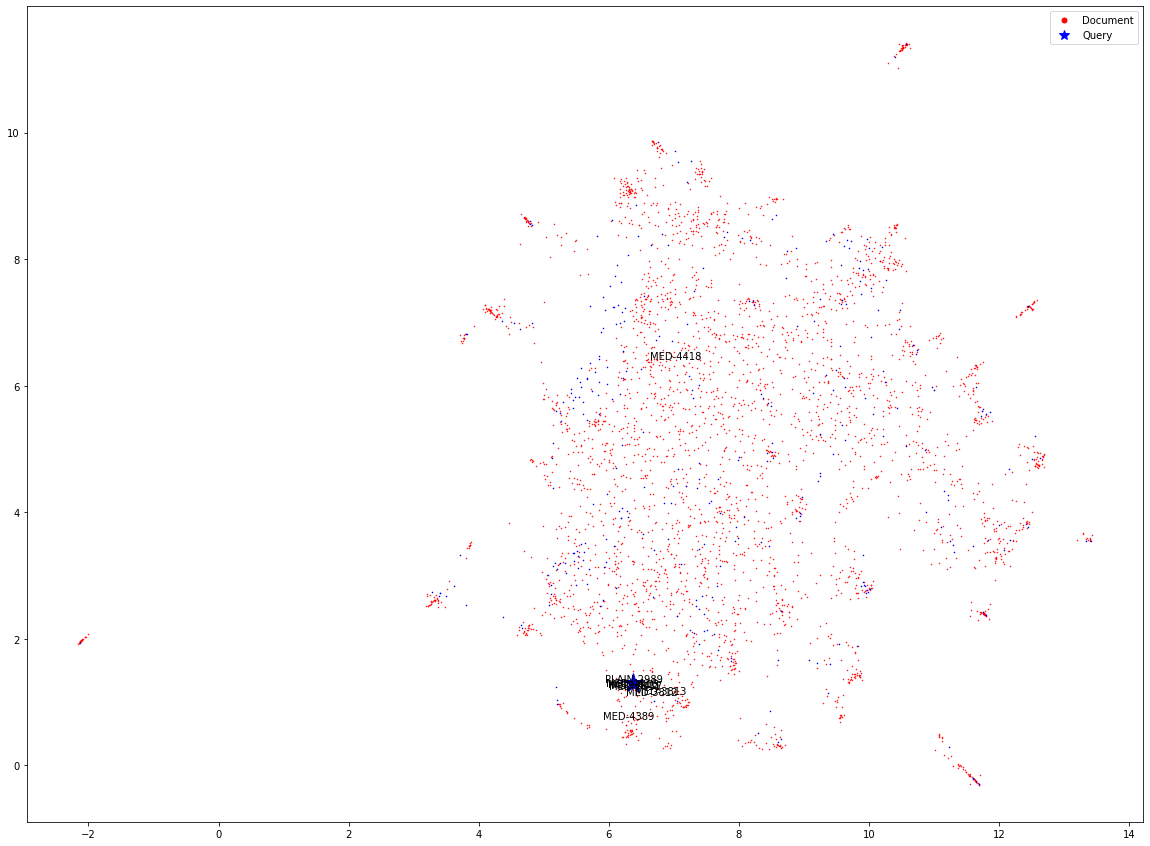

In [ ]:
visualize_embeddings(docs_embeddings_reduced, docs_ids, list(test_docid_text.keys()), q_embeddings_reduced, idx, query_id)

It can be clearly seen that the latent space is still spread but a little more clustered than before the training. Also, the embeddings of the query under analysis and most of its relevant documents collapse in close proximity.

### Documents retrieval

After obtaining the embeddings of queries and documents, they can be used for running information retrieval search on the corpus.

#### Cosine Similarity

First, it may be interesting to compute the cosine similarity between one query embedding and all documents embeddings, and to find out the pairs *query-document* with highest cosine similarity scores.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

cos_scores = util.cos_sim(q_embeddings[idx], docs_embeddings)[0]
top_results = torch.topk(cos_scores, k=10)

print("Query:", list(test_qid_text.keys())[idx])
print()
print('Clean text:', test_qid_text[query])
print("\nTop 10 most similar sentences in corpus:")

for score, i in zip(top_results[0], top_results[1]):
    print(list(test_docid_text.keys())[i], "(Score: {:.4f})".format(score))

df_relevant_docs = df_test[df_test['QUERY_ID']==query].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"{row['DOC_ID']} (Relevance: {row['RELEVANCE_LEVEL']})")

Query: PLAIN-2989

Clean text: safer cinnamonsecond spice popularity black pepper cinnamon powdered inner bark four different species cinnamomum trees theres vietnamese cinnamom chinese cinnamon indonesian ceylon recent review raised concerns one compound called coumarin new human data suggests may toxic liver banned food additive still found naturally chinese cinnamon also known cassia cinnamon found significant amounts socalled true cinnamon ceylon cinnamon dont enough data two traffic lights recreational users people going way add like teaspoon daily diet ideally everyone since appears amazingly health promoting antiinflammatory antimicrobial antioxidant antitumor cardiovascular cholesterollowering immunomodulatory effects especially useful diabetes prediabeties eating cinnamon every day great make sure right kind uk says cinnamon ceylon cinnamonchinese cinnamon labeled cassia us though theyre labeled cinnamon since chinese cheaper thats cinnamon shelves make sure specifically says 

#### K-NN search

For perfoming information retrieval, the algorithm employed is the K-Nearest Neighbor search, using Faiss library.

##### L2-distance

For speeding up the computations, the search is run on the GPU. The first experiment is run using the L2-distance search for retrieving the top-10 nearest neighbors for each query.

In [ ]:
res = faiss.StandardGpuResources()

d = q_embeddings.shape[1] # embedding dimension
print('The embeddings dimension is', d)
l2_index = faiss.IndexFlatL2(d)
l2_index.add(docs_embeddings)
gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, l2_index)

The embeddings dimension is 256


In [ ]:
k = 10
L2_D, L2_I = gpu_index_l2.search(q_embeddings, k)

check_queries = 10 # print the first 10 queries results

print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{L2_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[ 919 1237  921  341  922  926 2608 3288 1550 3291]
 [2504 1332 2512 3206 2749 3197 2002  501  494 3194]
 [2489 2488 2429 1885 2811 2256 2485 2163 1632 1884]
 [2489 1632 2811 2488 1639 2485 1628 1638 2078 1447]
 [ 260 1645 1660 1648 1779 2721 2952 3013 2249 1788]
 [2801 2799 1882 2798 2269 3273 1885 1764 1549 2787]
 [1653  721 1657  584  898  726  362 1649 1660 1652]
 [1663 1664 1665 3057 1214 3204 2435 3216 2148 3197]
 [1689 1676 1694 1688 1687 1699 1681 2181 1690 1700]
 [2752 2751  564  560  411  409 2753  565 2884  412]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)

for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4415 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2783 Relevance: 0
Doc: MED-2791 Relevance: 0
Doc: MED-3810 Relevance: 0
Doc: MED-2794 Relevance: 0


##### PCA reduction

Trying to improve performances, the embeddings dimension is reduced from $256$ to $32$ using PCA reduction.

In [ ]:
d_prime = 32
d = q_embeddings.shape[1]

pca_index = index_factory(d, f"PCA{d_prime},Flat")
pca_index.train(docs_embeddings)
pca_index.add(docs_embeddings)

PCA_D, PCA_I = pca_index.search(q_embeddings, k) # actual search
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{PCA_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[ 919  341 1237  926 2608  921 3291  922 1550 2681]
 [ 916  966  940 1782 3073 1332 2504 1564 2316 3209]
 [2488 1885 2489 2429 2485 2164 2268 2256 2811 1638]
 [2489 1639 2811 1628 1632 2488 1638 2485 1447 1624]
 [ 260 1645 1660 2721 2952 1778 1779 3263  653 2016]
 [2799 1549 2801 1882 2798 1764 3273 2269 2787  108]
 [ 721 1653 1649  726 1657 1652  557  584  898  362]
 [1664 1663 1665 3216 3057 1644 1214 3204 1444 2435]
 [1689 1676 1694 1688 2181 1687 1681 1699 1690 1692]
 [2752 2751 1317  560  564 2884 1314  409  411  565]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-4416 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4415 Relevance: 2
Doc: MED-2794 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-3810 Relevance: 0
Doc: MED-3807 Relevance: 0
Doc: MED-5000 Relevance: 0


##### Comparison

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print('First 10 documents retrieved by L2 index for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)


print('\nFirst 10 documents retrieved by PCA index for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved by L2 index for the query: PLAIN-2989
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4415 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2783 Relevance: 0
Doc: MED-2791 Relevance: 0
Doc: MED-3810 Relevance: 0
Doc: MED-2794 Relevance: 0

First 10 documents retrieved by PCA index for the query: PLAIN-2989
Doc: MED-4416 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4415 Relevance: 2
Doc: MED-2794 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-3810 Relevance: 0
Doc: MED-3807 Relevance: 0
Doc: MED-5000 Relevance: 0


##### Error analysis

Let's analyze a couple of missed relevant documents and one of those wrongly retrieved.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')

print('\nFirst 10 documents retrieved for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

df_relevant_docs = df_test[df_test['QUERY_ID']=='PLAIN-2989'].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"Doc: {row['DOC_ID']} Relevance: {row['RELEVANCE_LEVEL']}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the wrongly retrieved documents

wrong_doc_1 = 'MED-3951'
wrong_doc_2 = 'MED-2783'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {wrong_doc_1}: {docs[docs['DOC_ID'] == wrong_doc_1]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_1}: {test_docid_text[wrong_doc_1]}")
print()
print(f"Original text doc {wrong_doc_2}: {docs[docs['DOC_ID'] == wrong_doc_2]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_2}: {test_docid_text[wrong_doc_2]}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the missed relevant documents

missed_doc = 'MED-3813'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {missed_doc}: {docs[docs['DOC_ID']==missed_doc]['ABSTRACT'].values[0]}")
print(f"Clean text doc {missed_doc}: {test_docid_text[missed_doc]}")
print()

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

### Evaluation

Let's now evaluate the retrieval search computed with the naive L2-distance.

In [ ]:
rp = np.average([r_precision(q, L2_I[i], test_docid_text, test_query_docs_rel_order) for  i, q in enumerate(test_qid_text.keys())])

print('R-precision:', rp)

for k in [1, 3, 5, 10]:
    pk = np.mean([precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    rk = np.mean([recall_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    f1_k = np.mean([f1_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    mapk = np.mean([mean_average_precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    ndcg_k = np.average([compute_ndcg_at_k(q, L2_I[i], test_docid_text, test_qd_rel, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])

    print()
    print(f'Precision@{k}:', pk)
    print(f'Recall@{k}:', rk)
    print(f'F1-score@{k}:', f1_k)
    print(f'MAP@{k}:', mapk)
    print(f'NDCG@{k}:', ndcg_k)

R-precision: 0.1077569561797756

Precision@1: 0.47129909365558914
Recall@1: 0.03140066444717073
F1-score@1: 0.052040515103714415
MAP@1: 0.03140066444717073
NDCG@1: 0.4350453172205438

Precision@3: 0.4199395770392749
Recall@3: 0.06607663175750393
F1-score@3: 0.09146119958457742
MAP@3: 0.11157304633900501
NDCG@3: 0.40887982383533095

Precision@5: 0.370392749244713
Recall@5: 0.08508354631473249
F1-score@5: 0.10707157254955635
MAP@5: 0.1955493301743324
NDCG@5: 0.38777660117029106

Precision@10: 0.3057401812688822
Recall@10: 0.1282372228080785
F1-score@10: 0.13325103713360248
MAP@10: 0.4178162120015961
NDCG@10: 0.36340130533332143


## Triplet Loss

### Data formatting

Before feeding the model, data must be formatted properly. In particular, to be able to train the model using Triplet Loss, the input must be in the format *(anchor, positive, negative)*, where *anchor* is the query, *positive* is one relevant document and *negative* is one non-relevant document.

Since the dataset only contains pairs of *(anchor, positive)*, the negative must be set manually using the `triplets_format` function.

In [ ]:
df_train_triplets = triplets_format(df_train, train_qid_text, train_docid_text)
df_val_triplets = triplets_format(df_val, val_qid_text, val_docid_text)
df_test_triplets = triplets_format(df_test, test_qid_text, test_docid_text)

In [ ]:
df_train_triplets

,QUERY_ID,POS_DOC_ID,NEG_DOC_ID,TEXT_Q,TEXT_POS_DOC,TEXT_NEG_DOC,RELEVANCE_LEVEL
0,PLAIN-755,MED-2436,MED-1664,breast cancermuch like types cancer plantbased...,abstract content low density lipoprotein ldl r...,abstract intervertebral disc cartilaginous str...,1
1,PLAIN-755,MED-2437,MED-3516,breast cancermuch like types cancer plantbased...,abstract background breast cancer commonly dia...,abstract topical application capsaicin human n...,1
2,PLAIN-755,MED-2438,MED-5063,breast cancermuch like types cancer plantbased...,abstract phytoestrogens structurally similar e...,evidence supports trial period eliminating col...,1
3,PLAIN-755,MED-2439,MED-3976,breast cancermuch like types cancer plantbased...,abstract many factors involved etiology cancer...,abstract objectives investigate effect dog cat...,1
4,PLAIN-755,MED-2440,MED-4704,breast cancermuch like types cancer plantbased...,abstract purpose clarify relationship total ch...,abstract introduction lipoid pneumonia rare fo...,1
...,...,...,...,...,...,...,...
50925,PLAIN-3348,MED-5021,MED-3893,star fruit good youstar fruit often find tropi...,abstract previously discovered star fruit indu...,abstract seven cyclists exercised maximal upta...,2
50926,PLAIN-3377,MED-5059,MED-1148,gum arabic harmfulgum arabic found paints mars...,abstract report represents conclusions joint f...,abstract purpose etiology hypospadias poorly u...,2
50927,PLAIN-428,MED-924,MED-3730,making water alkaline much baking soda muchhtt...,abstract oral ingestion baking soda sodium bic...,abstract dysplasia histologic precursor esopha...,2
50928,PLAIN-428,MED-925,MED-2278,making water alkaline much baking soda muchhtt...,abstract present case sixweekold infant develo...,abstract objectives investigate antiinflammato...,2


### Training

In [ ]:
# Load a new bert-mini model

word_embedding_model = models.Transformer('prajjwal1/bert-mini')
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [ ]:
# Convert the dataframe into a dataset

train_ds = Dataset.from_pandas(df_train_triplets)
train_ds

Dataset({
    features: ['QUERY_ID', 'POS_DOC_ID', 'NEG_DOC_ID', 'TEXT_Q', 'TEXT_POS_DOC', 'TEXT_NEG_DOC', 'RELEVANCE_LEVEL'],
    num_rows: 50930
})

In [ ]:
# Format properly the input

train_samples = []
train_data = train_ds
n_samples = train_ds.num_rows

for i in range(n_samples):
  sample = train_data[i]
  train_samples.append(InputExample(texts=[sample['TEXT_Q'], sample['TEXT_POS_DOC'], sample['TEXT_NEG_DOC']]))

In [ ]:
# Collect train data into a dataloader

train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=32)

In [ ]:
# Define the loss function

train_loss = losses.TripletLoss(model=model, triplet_margin=0.1, distance_metric=TripletDistanceMetric.COSINE)

In [ ]:
# Define an evaluator on validation data

evaluator = evaluation.InformationRetrievalEvaluator(queries = val_qid_text,
                                                     corpus = val_docid_text,
                                                     relevant_docs = val_query_docs_rel_order,
                                                     accuracy_at_k = [1, 3, 5, 10],
                                                     precision_recall_at_k = [1, 3, 5, 10],
                                                     map_at_k = [1, 3, 5, 10],
                                                     show_progress_bar=True,
                                                     score_functions = {'cos_sim': cos_sim})

In [ ]:
# Train the model for 3 epochs

model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=3,
          evaluator=evaluator,
          output_path = 'model_triplet_loss',
          evaluation_steps = 5000,
          save_best_model=True)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.33s/it]


Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


Iteration:   0%|          | 0/1592 [00:00<?, ?it/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]


Corpus Chunks: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


In [ ]:
#model.save('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_triplet_loss')

Let's see the results of the $3$ epochs on the validation set.

In [ ]:
results = pd.read_csv('model_triplet_loss/eval/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10'], axis=1)
results

,epoch,cos_sim-Accuracy@1,cos_sim-Accuracy@3,cos_sim-Accuracy@5,cos_sim-Accuracy@10,cos_sim-Precision@1,cos_sim-Recall@1,cos_sim-Precision@3,cos_sim-Recall@3,cos_sim-Precision@5,cos_sim-Recall@5,cos_sim-Precision@10,cos_sim-Recall@10,cos_sim-MAP@1,cos_sim-MAP@3,cos_sim-MAP@5,cos_sim-MAP@10
0,0,0.341390,0.558912,0.658610,0.746224,0.341390,0.028391,0.283988,0.054309,0.267069,0.075274,0.215408,0.102475,0.341390,0.242028,0.211039,0.161371
1,1,0.380665,0.567976,0.685801,0.767372,0.380665,0.032441,0.307150,0.053998,0.297885,0.075385,0.246526,0.111688,0.380665,0.273246,0.242402,0.189082
2,2,0.401813,0.601208,0.694864,0.785498,0.401813,0.028042,0.342397,0.058798,0.306344,0.080231,0.252568,0.115842,0.401813,0.300856,0.254503,0.195239


In [ ]:
# Reload the model

#model = SentenceTransformer('/content/drive/MyDrive/Colab Notebooks/sentence_transformer/bert_mini_triplet_loss')

In [ ]:
#! mkdir '/content/triplet_loss'

In [ ]:
#evaluator(model, output_path='/content/triplet_loss')

In [ ]:
#results = pd.read_csv('/content/triplet_loss/Information-Retrieval_evaluation_results.csv').drop(['steps','cos_sim-MRR@10','cos_sim-NDCG@10','epoch'], axis=1)
#results

### Latent space visualization after model training

Let the trained model to generate embeddings for test queries and documents.

In [ ]:
docs_embeddings = model.encode(list(test_docid_text.values()), convert_to_tensor=True)
q_embeddings = model.encode(list(test_qid_text.values()), convert_to_tensor=True)

docs_embeddings = docs_embeddings.cpu().numpy()
q_embeddings = q_embeddings.cpu().numpy()

In [ ]:
idx = list(test_qid_text.keys()).index('PLAIN-2989')
query_id = list(test_qid_text.keys())[idx]
query_text = list(test_qid_text.values())[idx]
query_id

'PLAIN-2989'

In [ ]:
docs_ids = test_query_docs_rel_order[query_id]
docs_text = [test_docid_text[d] for d in docs_ids]
docs_ids

['MED-3811',
 'MED-3812',
 'MED-3813',
 'MED-4389',
 'MED-4415',
 'MED-4416',
 'MED-4417',
 'MED-4418']

In [ ]:
umap_visualizer = umap.UMAP(random_state = 56)
umap_visualizer.fit(np.concatenate((docs_embeddings,q_embeddings)))
docs_embeddings_reduced = umap_visualizer.transform(docs_embeddings)
q_embeddings_reduced = umap_visualizer.transform(q_embeddings)

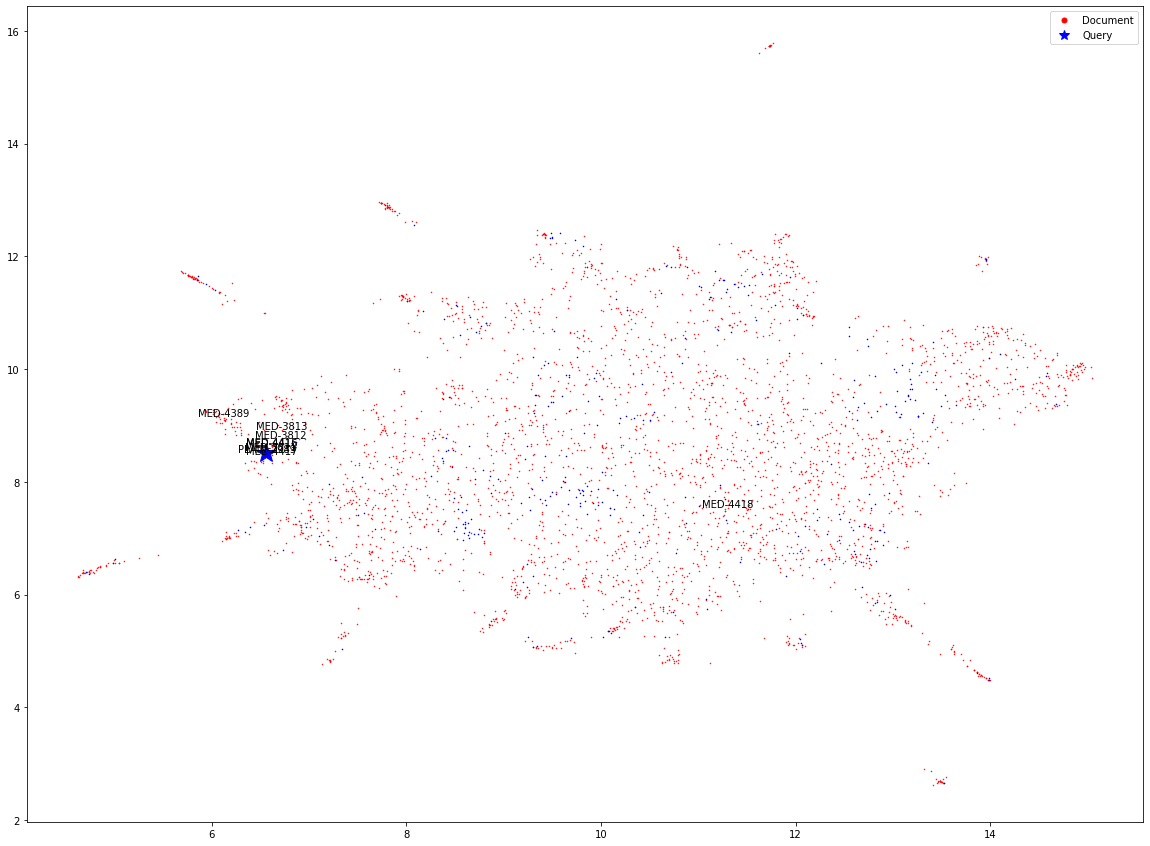

In [ ]:
visualize_embeddings(docs_embeddings_reduced, docs_ids, list(test_docid_text.keys()), q_embeddings_reduced, idx, query_id)

It can be clearly seen that the latent space is still spread but more clustered than before the training. Also, the embeddings of the query under analysis and most of its relevant documents collapse in close proximity.

### Documents retrieval

After obtaining the embeddings of queries and documents, they can be used for running information retrieval search on the corpus.

#### Cosine Similarity

First, it may be interesting to compute the cosine similarity between one query embedding and all documents embeddings, and to find out the pairs *query-document* with highest cosine similarity scores.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

cos_scores = util.cos_sim(q_embeddings[idx], docs_embeddings)[0]
top_results = torch.topk(cos_scores, k=10)

print("Query:", list(test_qid_text.keys())[idx])
print()
print('Clean text:', test_qid_text[query])
print("\nTop 10 most similar sentences in corpus:")

for score, i in zip(top_results[0], top_results[1]):
    print(list(test_docid_text.keys())[i], "(Score: {:.4f})".format(score))

df_relevant_docs = df_test[df_test['QUERY_ID']==query].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"{row['DOC_ID']} (Relevance: {row['RELEVANCE_LEVEL']})")

Query: PLAIN-2989

Clean text: safer cinnamonsecond spice popularity black pepper cinnamon powdered inner bark four different species cinnamomum trees theres vietnamese cinnamom chinese cinnamon indonesian ceylon recent review raised concerns one compound called coumarin new human data suggests may toxic liver banned food additive still found naturally chinese cinnamon also known cassia cinnamon found significant amounts socalled true cinnamon ceylon cinnamon dont enough data two traffic lights recreational users people going way add like teaspoon daily diet ideally everyone since appears amazingly health promoting antiinflammatory antimicrobial antioxidant antitumor cardiovascular cholesterollowering immunomodulatory effects especially useful diabetes prediabeties eating cinnamon every day great make sure right kind uk says cinnamon ceylon cinnamonchinese cinnamon labeled cassia us though theyre labeled cinnamon since chinese cheaper thats cinnamon shelves make sure specifically says 

#### K-NN search

For perfoming information retrieval, the algorithm employed is the K-Nearest Neighbor search, using Faiss library.

##### L2-distance

For speeding up the computations, the search is run on the GPU. The first experiment is run using the L2-distance search for retrieving the top-10 nearest neighbors for each query.

In [ ]:
res = faiss.StandardGpuResources()

d = q_embeddings.shape[1] # embedding dimension
print('The embeddings dimension is', d)
l2_index = faiss.IndexFlatL2(d)
l2_index.add(docs_embeddings)
gpu_index_l2 = faiss.index_cpu_to_gpu(res, 0, l2_index)

The embeddings dimension is 256


In [ ]:
k = 10
L2_D, L2_I = gpu_index_l2.search(q_embeddings, k)

check_queries = 10 # print the first 10 queries results

print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{L2_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[ 921 1237  919  923  509 1550  926  922 3288  690]
 [ 539  537 3197 3205 2749 2204 3206 1380 2002 2049]
 [3210 1624  602 1632 2812 1628 2489 2811 3198 2163]
 [1628 2489 1630 3141 1447 2004 1466 1632 1092 2490]
 [1648  260 1645 3202 2016 3208 1153  377 1788  972]
 [2799 1621 2801 3210 1633 2798   21 2269 2087 2085]
 [ 898 3200  726 3197 2389 3205 1649 2236  101 3216]
 [3197 1913  709 3057 3204 2995 3213 2649 3216 3198]
 [1689 1676 1694 1681 1685 1687 1690 1688 1699 3201]
 [2752 1561 2751 2059 2657 2884 1092 1566 1221  560]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)

for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4415 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2810 Relevance: 0
Doc: MED-3951 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-2813 Relevance: 0


##### PCA reduction

Trying to improve performances, the embeddings dimension is reduced from $256$ to $32$ using PCA reduction.

In [ ]:
d_prime = 32
d = q_embeddings.shape[1]

pca_index = index_factory(d, f"PCA{d_prime},Flat")
pca_index.train(docs_embeddings)
pca_index.add(docs_embeddings)

PCA_D, PCA_I = pca_index.search(q_embeddings, k) # actual search
print(f"Indices of the nearest neighbors of the first {check_queries} queries\n{PCA_I[:check_queries]}\n")

Indices of the nearest neighbors of the first 10 queries
[[ 921  919 1237  509  923  926  690 2608  922 1550]
 [ 537  539 2630 3197 3206 3073 1808 1349 2576 2206]
 [3210 1624  602 2812 1632 2811 1628 2208 1638 2488]
 [1628 1630 1447 3141 1466 2208 2490 2489 2004 2995]
 [ 260 1648 2016 1645 3213 2649 1153 3202 3208 2952]
 [1621 2799 1041   21 1633 1549  152 2798 1888 3210]
 [ 898 3200 3216 2951 2953  726 1649 3197  260 2389]
 [3197  709 2995 1913 1978 3216 1586 3211 3204 3057]
 [1689 1694 1676 1681 1685 1690 3201 1678 1688 1687]
 [2752 2884 1561 2751  560 2657 2755 1314 1092 2059]]



In [ ]:
# Select a query and find its top-10 documents

query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)

print('First 10 documents retrieved for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-4416 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4418 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-2794 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-3469 Relevance: 0
Doc: MED-3951 Relevance: 0


##### Comparison

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print('First 10 documents retrieved by L2 index for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)


print('\nFirst 10 documents retrieved by PCA index for the query:', query)


for i in PCA_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

First 10 documents retrieved by L2 index for the query: PLAIN-2989
Doc: MED-3811 Relevance: 1
Doc: MED-4416 Relevance: 2
Doc: MED-4415 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-4418 Relevance: 2
Doc: MED-2810 Relevance: 0
Doc: MED-3951 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-2813 Relevance: 0

First 10 documents retrieved by PCA index for the query: PLAIN-2989
Doc: MED-4415 Relevance: 2
Doc: MED-4416 Relevance: 2
Doc: MED-3811 Relevance: 1
Doc: MED-4418 Relevance: 2
Doc: MED-4417 Relevance: 2
Doc: MED-5000 Relevance: 0
Doc: MED-2794 Relevance: 0
Doc: MED-2783 Relevance: 0
Doc: MED-3469 Relevance: 0
Doc: MED-3951 Relevance: 0


##### Error analysis

Let's analyze a couple of missed relevant documents and one of those wrongly retrieved.

In [ ]:
query = 'PLAIN-2989'
idx = list(test_qid_text.keys()).index(query)
print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')

print('\nFirst 10 documents retrieved for the query:', query)


for i in L2_I[idx]:
  d = list(test_docid_text.keys())[i]
  if d in test_query_docs_rel_order[query]:
    rel = test_qd_rel[(query, d)]
  else:
    rel = 0

  print('Doc:', d, 'Relevance:', rel)

df_relevant_docs = df_test[df_test['QUERY_ID']=='PLAIN-2989'].sort_values(by='RELEVANCE_LEVEL', ascending=False)

print('\nReal first relevant docs:')

for idx, row in df_relevant_docs.iterrows():
  print(f"Doc: {row['DOC_ID']} Relevance: {row['RELEVANCE_LEVEL']}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the wrongly retrieved documents

wrong_doc_1 = 'MED-5000'
wrong_doc_2 = 'MED-2810'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {wrong_doc_1}: {docs[docs['DOC_ID'] == wrong_doc_1]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_1}: {test_docid_text[wrong_doc_1]}")
print()
print(f"Original text doc {wrong_doc_2}: {docs[docs['DOC_ID'] == wrong_doc_2]['ABSTRACT'].values[0]}")
print(f"Clean text doc {wrong_doc_2}: {test_docid_text[wrong_doc_2]}")

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

In [ ]:
# Print the text of the query and of one of the missed relevant documents

missed_doc = 'MED-4389'

print(f"Original query text: {queries[queries['QUERY_ID']==query]['TEXT'].values[0]}")
print(f'Clean query text: {test_qid_text[query]}')
print()
print(f"Original text doc {missed_doc}: {docs[docs['DOC_ID']==missed_doc]['ABSTRACT'].values[0]}")
print(f"Clean text doc {missed_doc}: {test_docid_text[missed_doc]}")
print()

Original query text: The Safer CinnamonSecond in spice popularity only to black pepper, cinnamon is the powdered inner bark of four different species of cinnamomum trees. There’s Vietnamese cinnamom, Chinese cinnamon, Indonesian, and Ceylon. A recent review raised concerns about one of them because of a compound called coumarin, which new human data suggests may be toxic to the liver. It’s been banned as a food additive, but still can be found naturally in, Chinese cinnamon, also known as cassia cinnamon. It is not found in significant amounts in so-called true cinnamon, Ceylon cinnamon, and we don’t have enough data on the other two. Now these traffic lights are not for recreational users; these are only for people going out of their way to add like a teaspoon or more to their daily diet, which ideally should be everyone, since it appears so amazingly health promoting— anti-inflammatory, antimicrobial, antioxidant, antitumor, cardiovascular, cholesterol-lowering, and immunomodulatory 

### Evaluation

Let's now evaluate the retrieval search computed with the naive L2-distance.

In [ ]:
rp = np.average([r_precision(q, L2_I[i], test_docid_text, test_query_docs_rel_order) for  i, q in enumerate(test_qid_text.keys())])

print('R-precision:', rp)

for k in [1, 3, 5, 10]:
    pk = np.mean([precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    rk = np.mean([recall_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    f1_k = np.mean([f1_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    mapk = np.mean([mean_average_precision_at_k(q, L2_I[i], test_docid_text, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])
    ndcg_k = np.average([compute_ndcg_at_k(q, L2_I[i], test_docid_text, test_qd_rel, test_query_docs_rel_order, k) for i, q in enumerate(test_qid_text.keys())])

    print()
    print(f'Precision@{k}:', pk)
    print(f'Recall@{k}:', rk)
    print(f'F1-score@{k}:', f1_k)
    print(f'MAP@{k}:', mapk)
    print(f'NDCG@{k}:', ndcg_k)

R-precision: 0.09053554061796558

Precision@1: 0.4169184290030212
Recall@1: 0.027095077989807523
F1-score@1: 0.045343273614532095
MAP@1: 0.027095077989807523
NDCG@1: 0.3776435045317221

Precision@3: 0.3444108761329305
Recall@3: 0.05655980392760319
F1-score@3: 0.07815628784560033
MAP@3: 0.09088093519029128
NDCG@3: 0.3360519194496181

Precision@5: 0.3057401812688822
Recall@5: 0.07529183855886054
F1-score@5: 0.09335781883398489
MAP@5: 0.15759224457942217
NDCG@5: 0.319942849321346

Precision@10: 0.2513595166163142
Recall@10: 0.1105074871004861
F1-score@10: 0.11142492387165256
MAP@10: 0.3240977942341201
NDCG@10: 0.2992346243867127


# Conclusions

Overall, due to computational limitations and the fairly challenging nature of the dataset and the task itself, performances of the model are good but not excellent.

From experiments, it turned out that the loss function that better allows the Sentence Transformer to learn meaningful embeddings is the Multiple Negative Ranking Loss.

The reason may be that it tries to mainly focus on hard negatives, letting the model to learn more similar embeddings for queries and relevant documents, while pushing away the non relevant ones.

It is important to underline that the MNR loss performs better according to both metrics which do not take into account the actual relevance of documents, i.e. precision, recall, f1-score, r-precision and MAP, and metrics which instead are relevance-aware, such as NDCG.